<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/step7_lumbar_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import adam_v2

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model

In [7]:
with open("/content/drive/MyDrive/segmentation/input_data/inputdata11.pkl", "rb") as fr:
    data = pickle.load(fr)

In [8]:
a = data[0]
b = data[1]

a = np.array(a)
b = np.array(b)

In [9]:
train_imgs = a[:200]
train_msks = b[:200]
valid_imgs = a[200:]
valid_msks = b[200:]

train_msks = train_msks.astype(np.float32)
valid_msks = valid_msks.astype(np.float32)

train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))

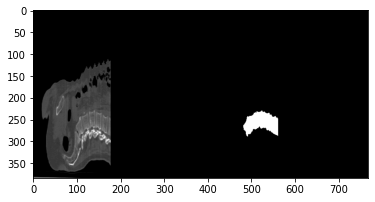

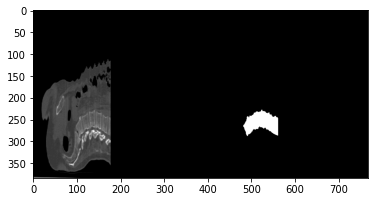

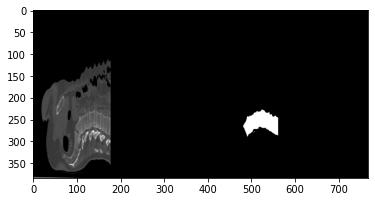

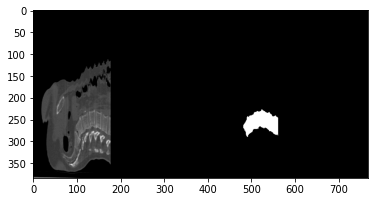

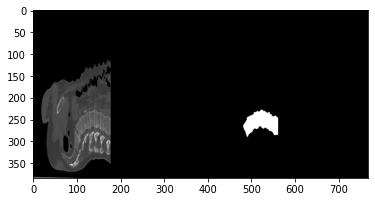

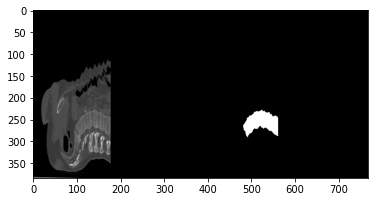

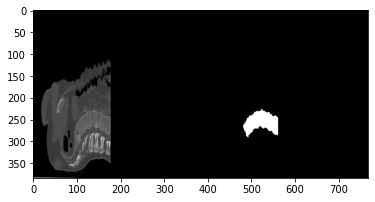

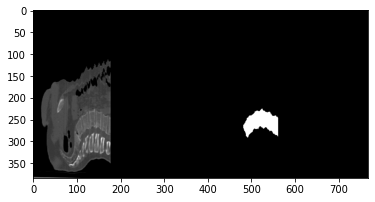

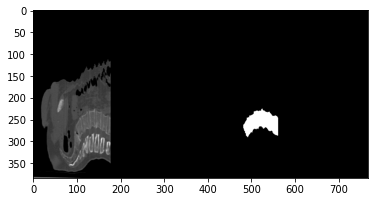

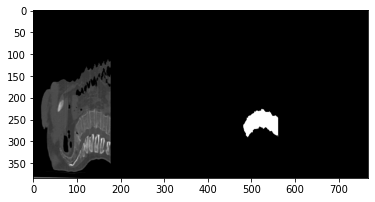

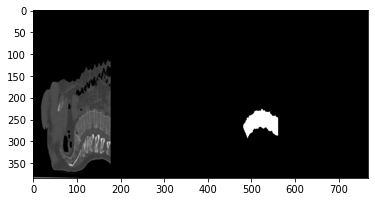

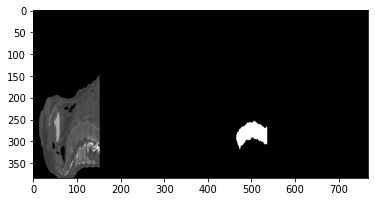

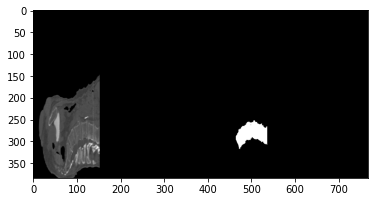

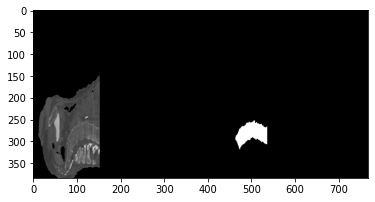

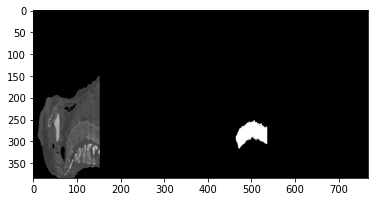

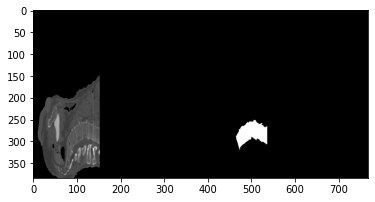

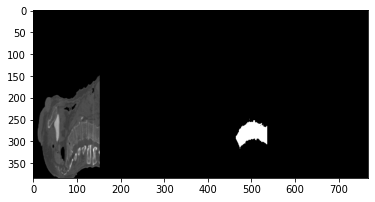

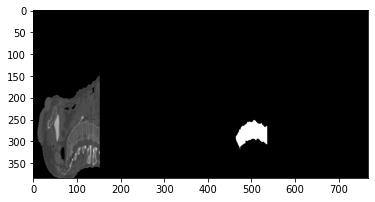

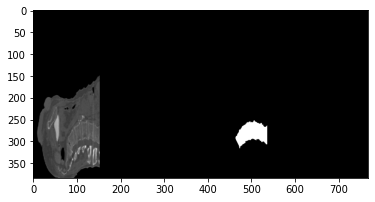

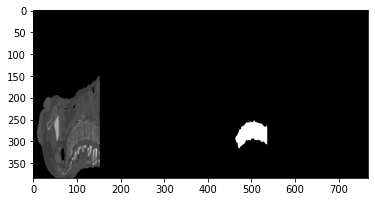

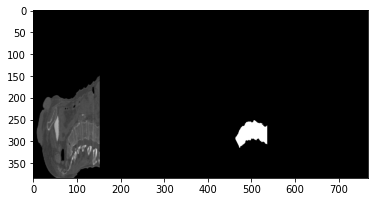

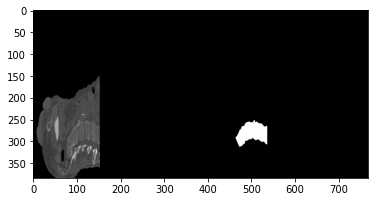

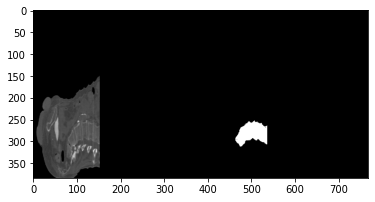

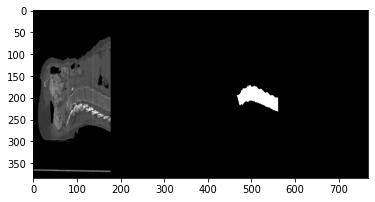

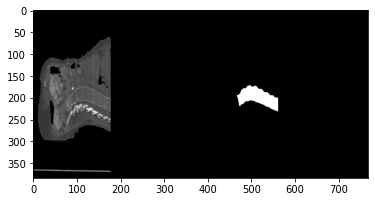

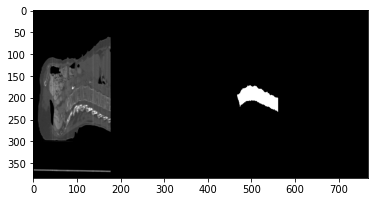

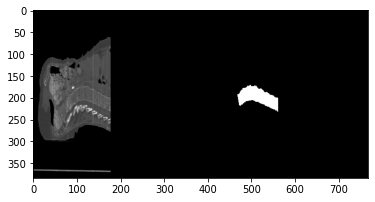

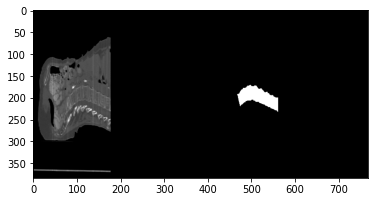

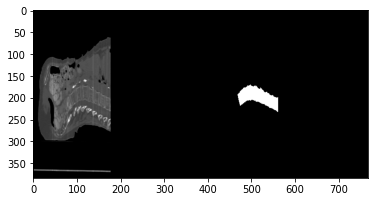

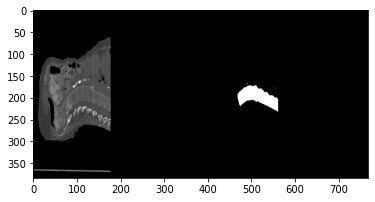

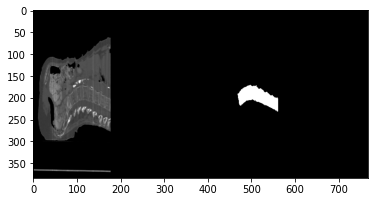

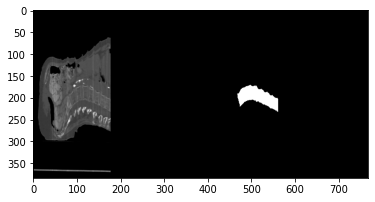

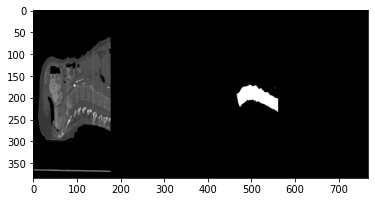

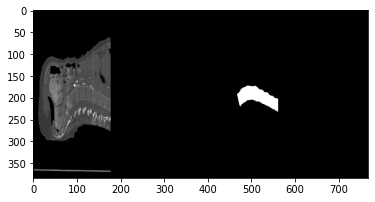

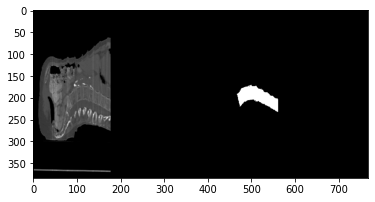

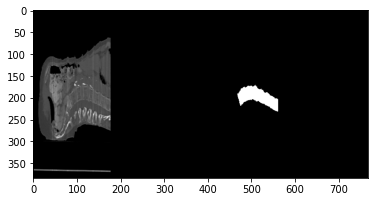

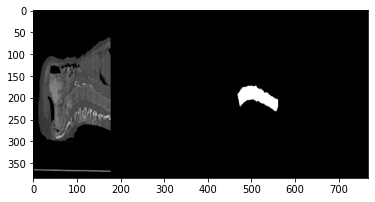

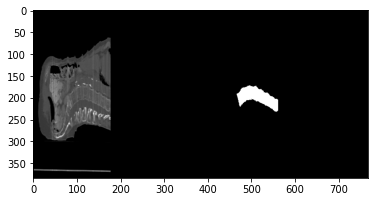

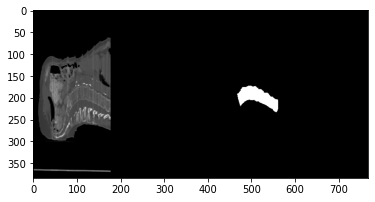

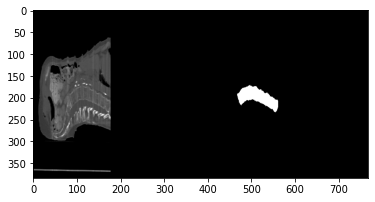

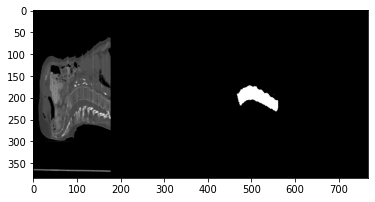

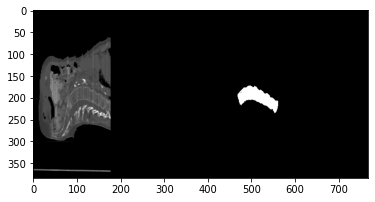

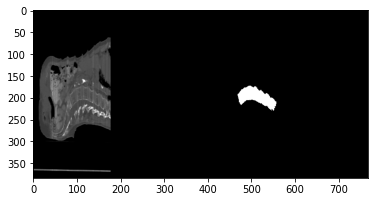

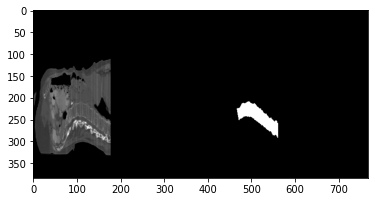

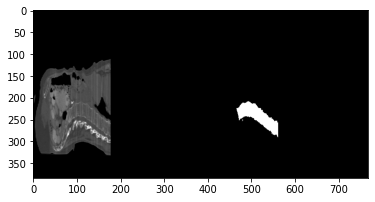

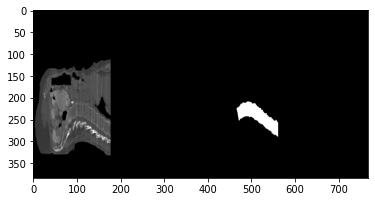

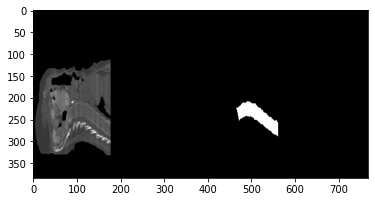

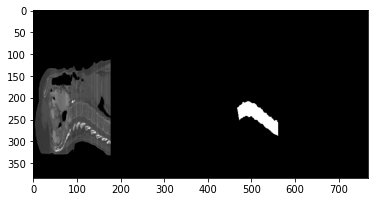

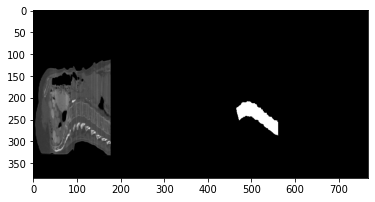

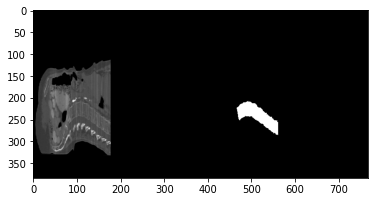

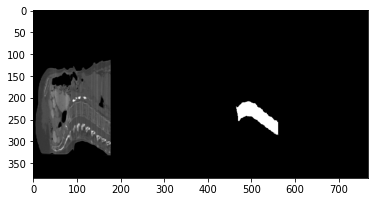

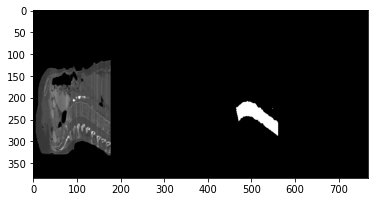

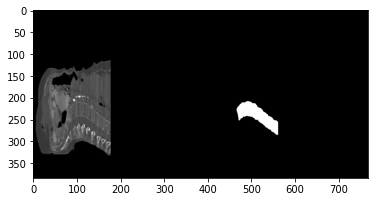

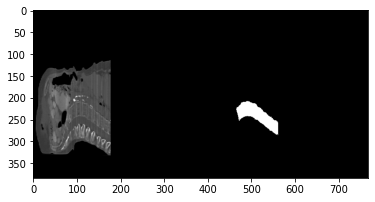

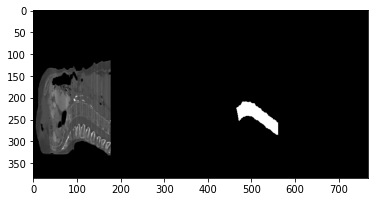

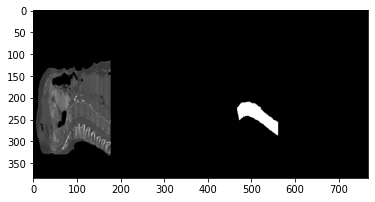

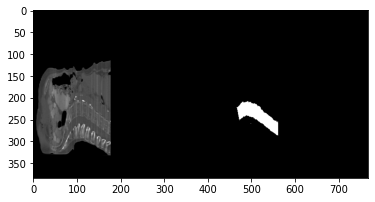

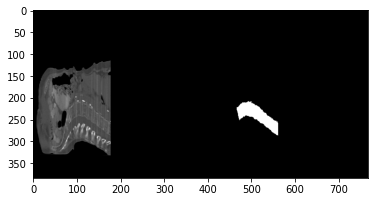

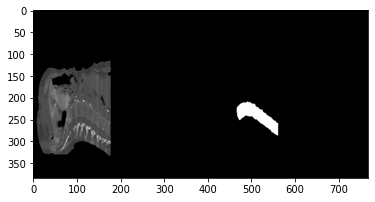

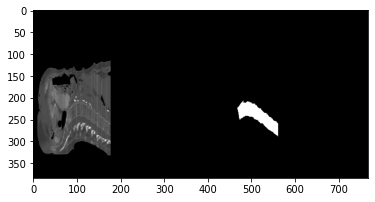

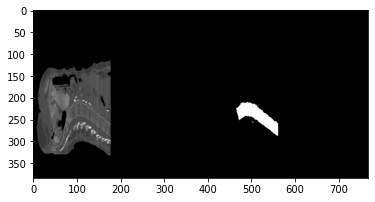

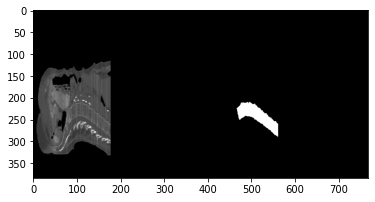

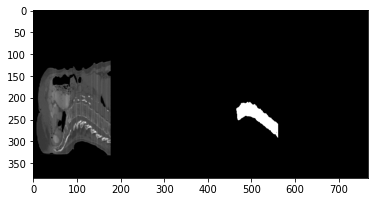

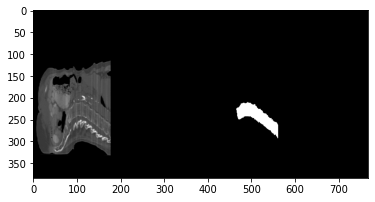

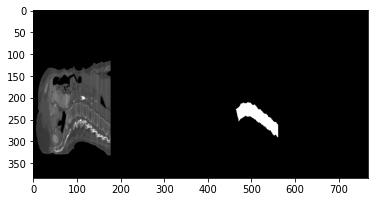

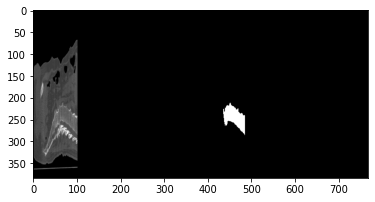

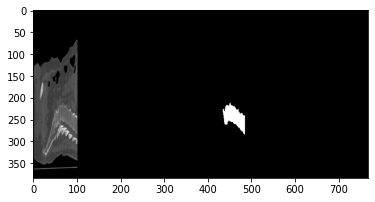

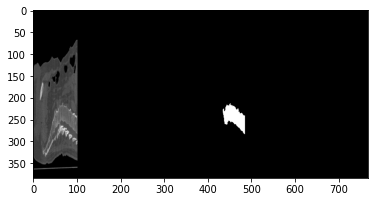

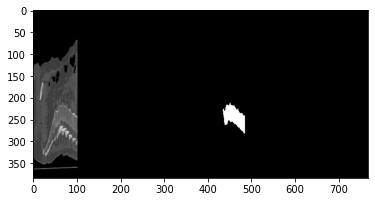

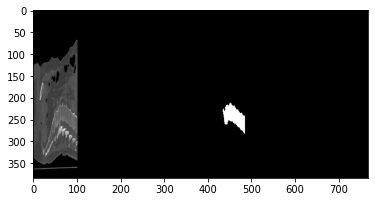

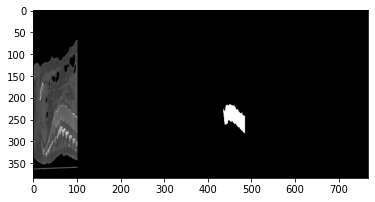

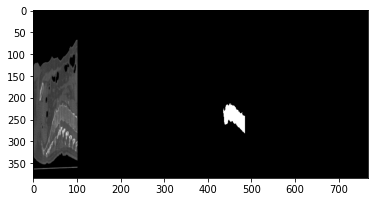

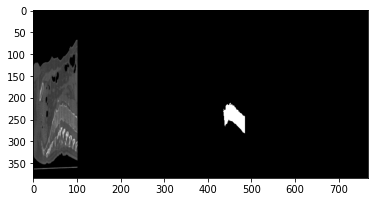

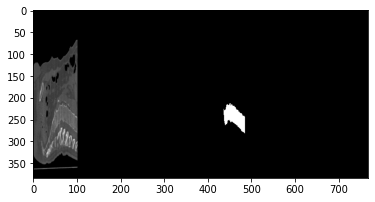

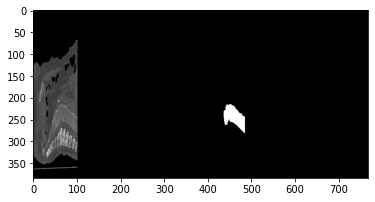

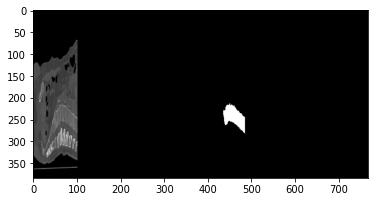

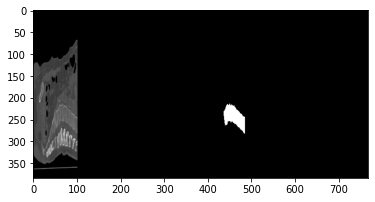

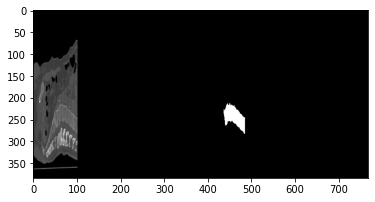

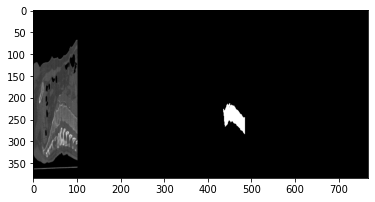

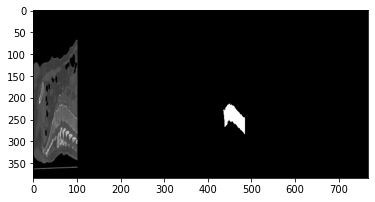

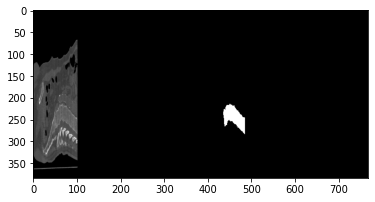

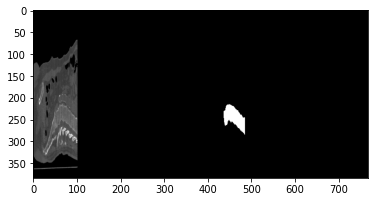

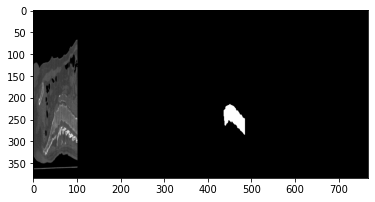

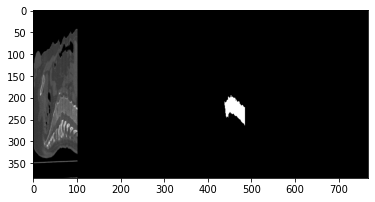

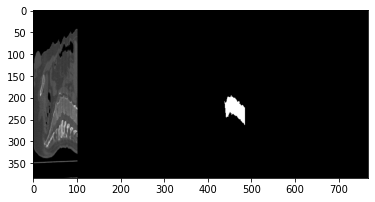

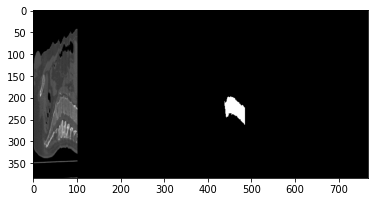

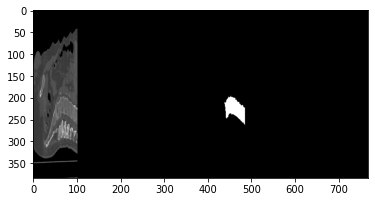

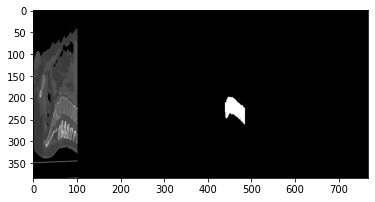

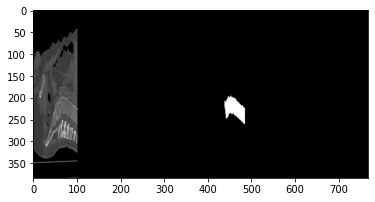

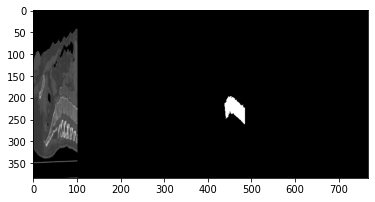

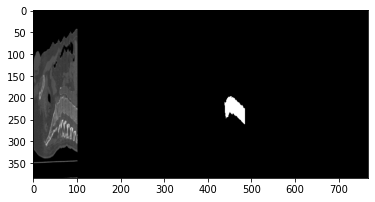

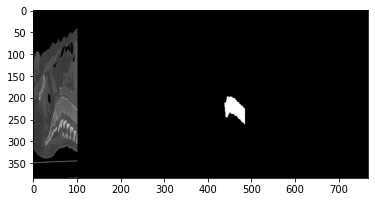

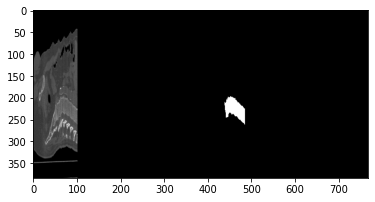

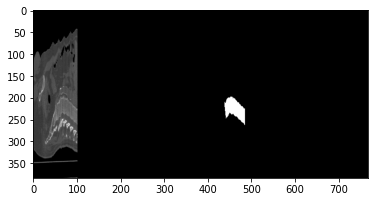

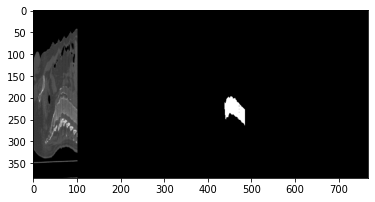

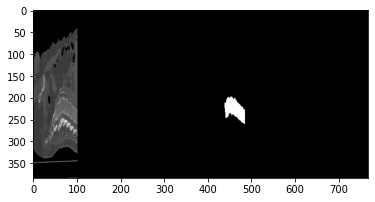

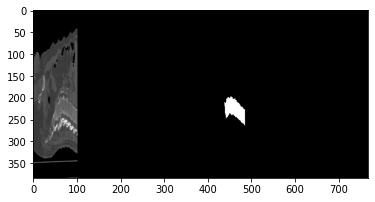

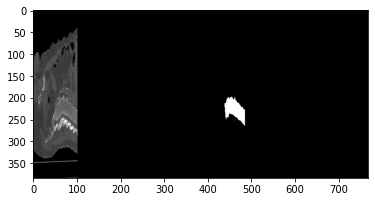

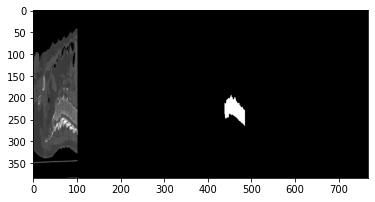

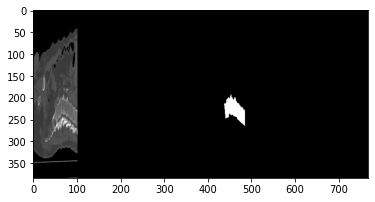

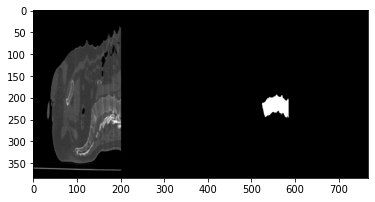

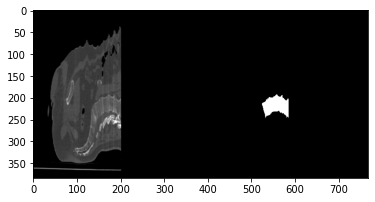

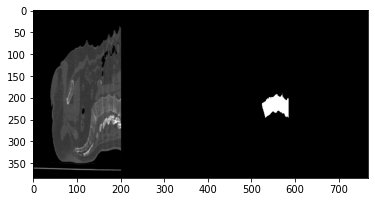

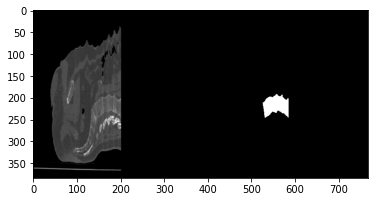

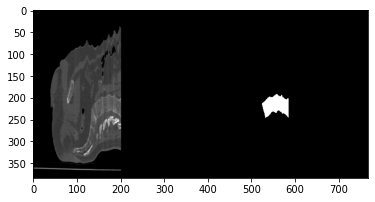

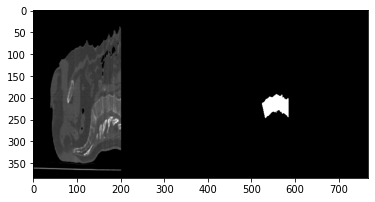

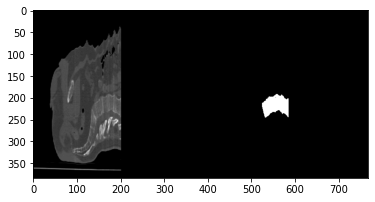

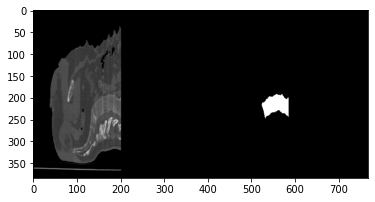

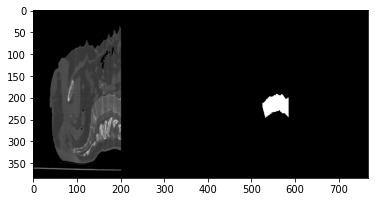

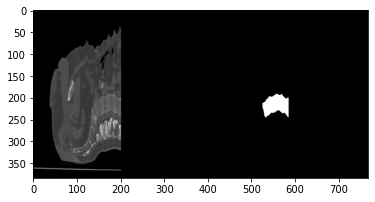

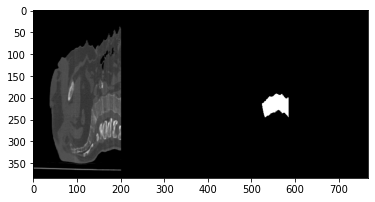

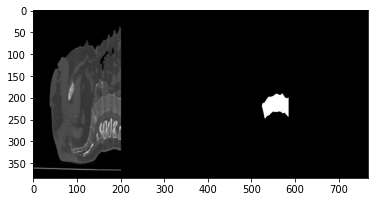

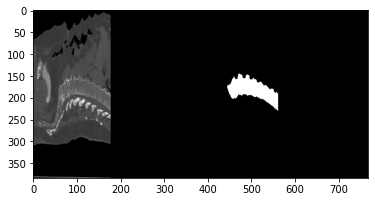

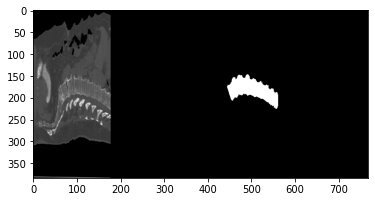

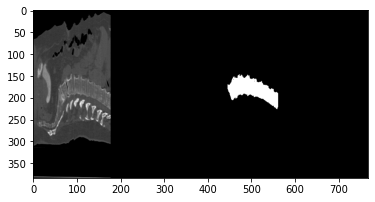

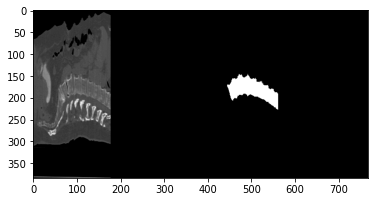

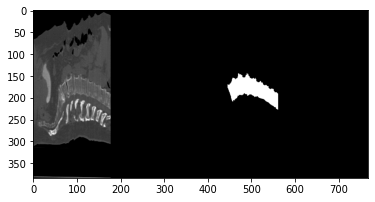

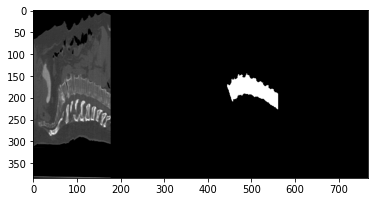

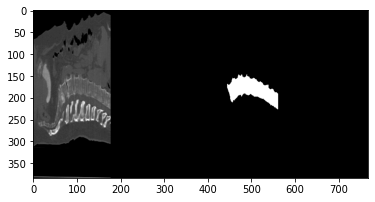

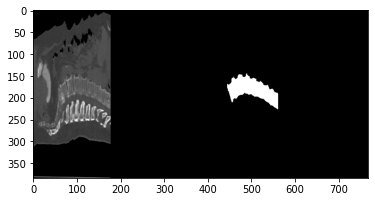

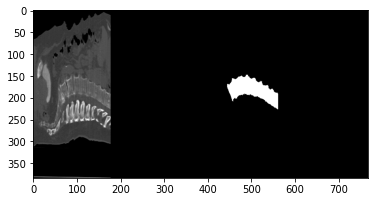

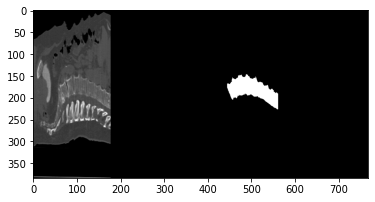

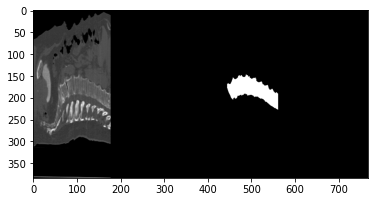

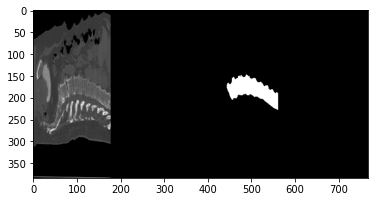

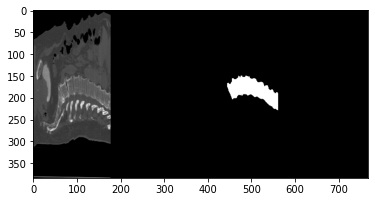

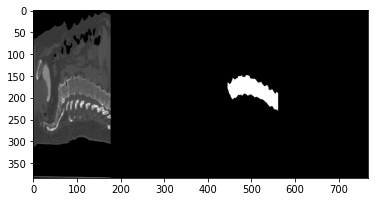

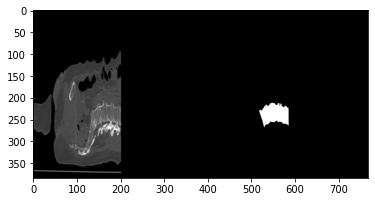

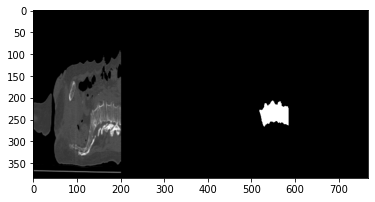

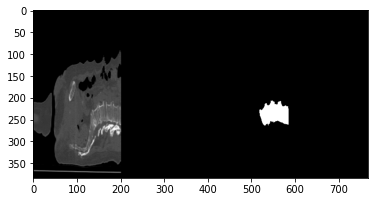

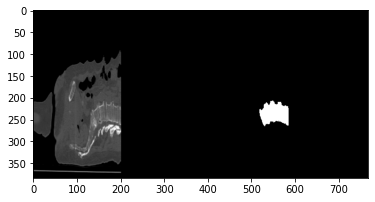

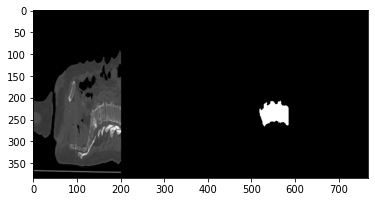

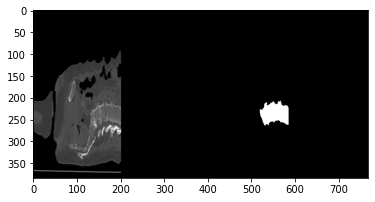

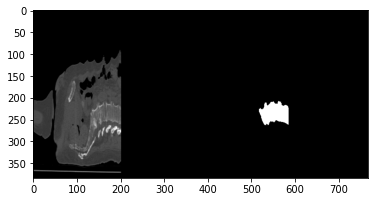

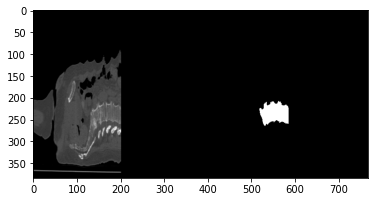

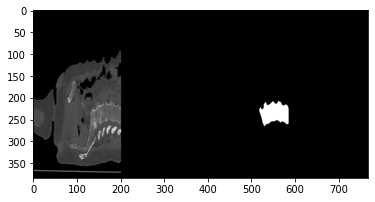

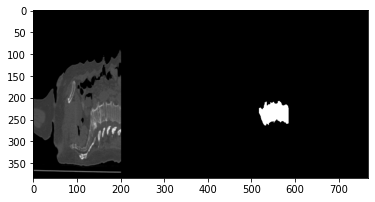

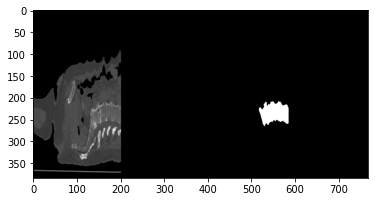

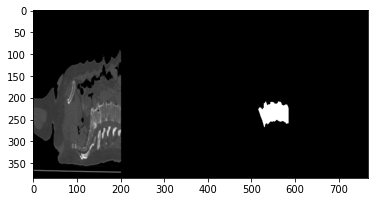

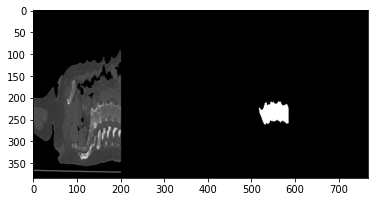

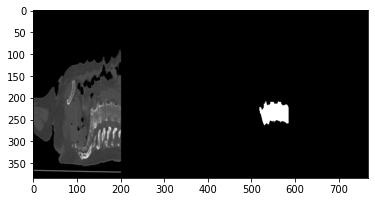

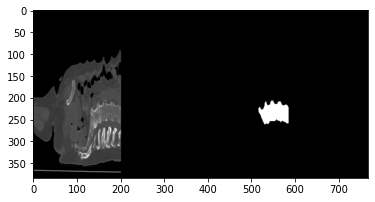

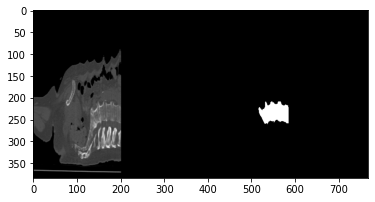

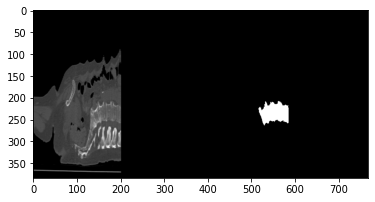

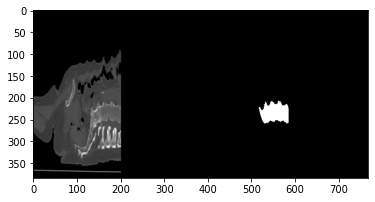

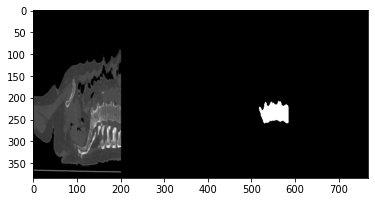

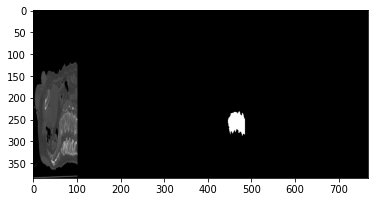

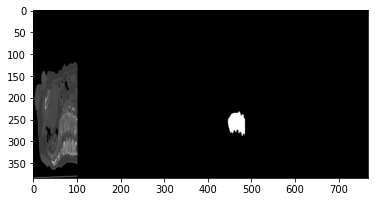

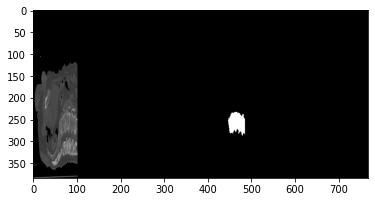

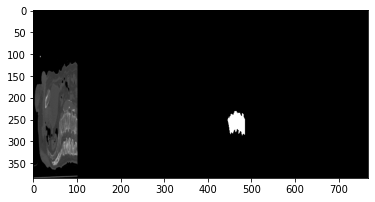

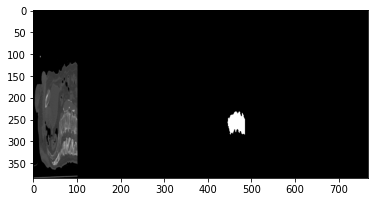

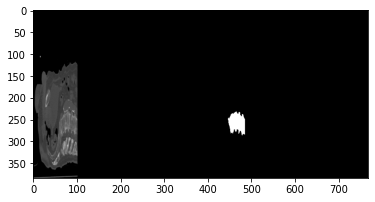

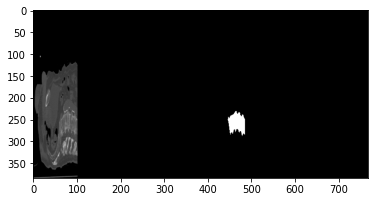

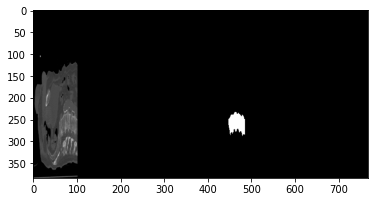

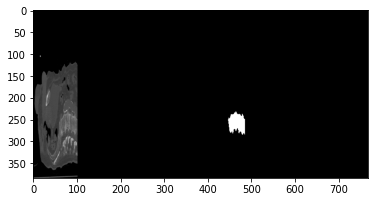

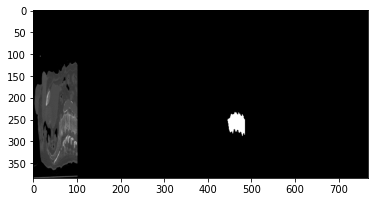

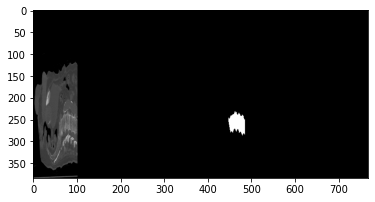

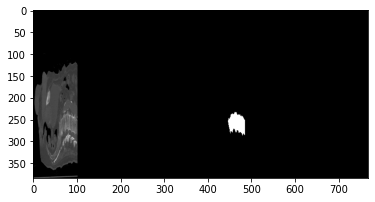

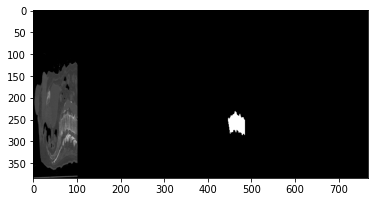

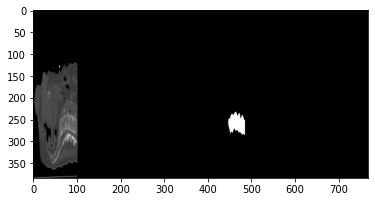

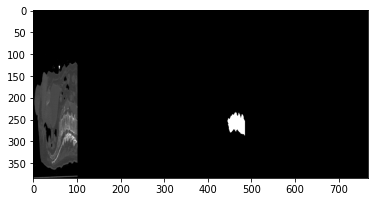

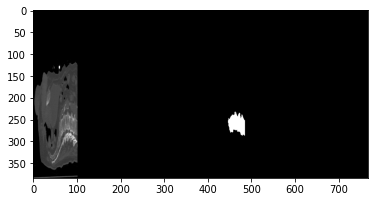

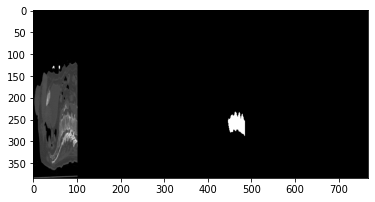

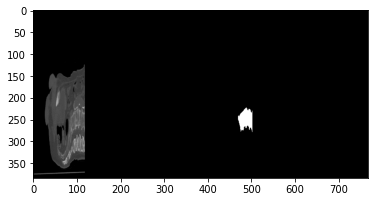

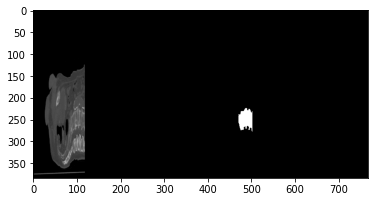

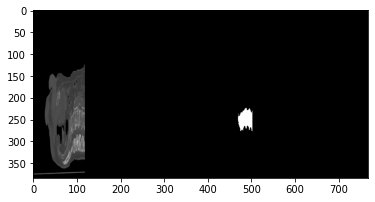

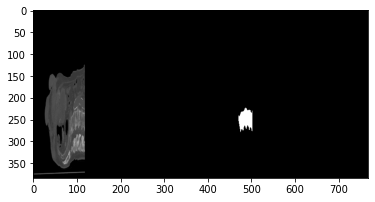

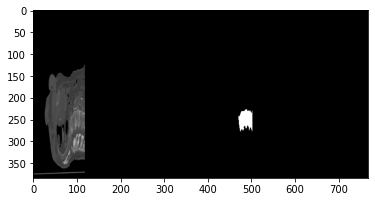

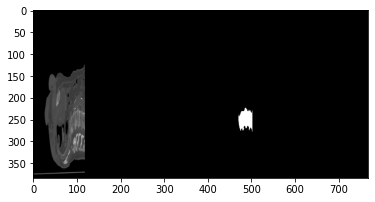

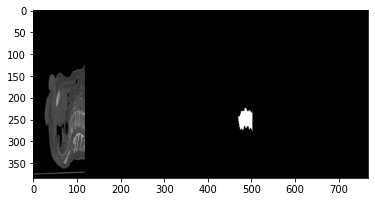

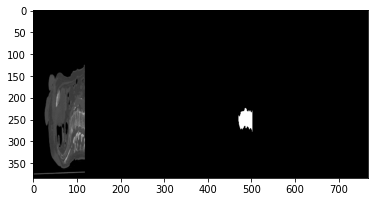

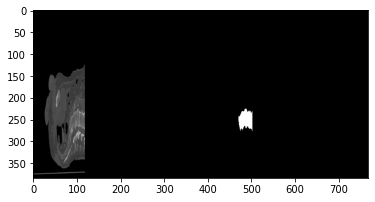

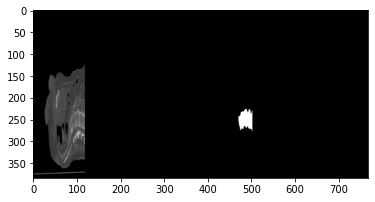

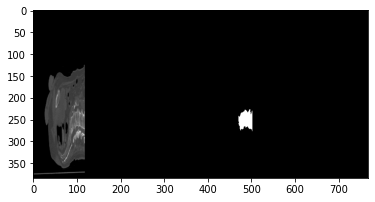

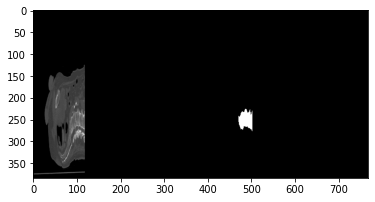

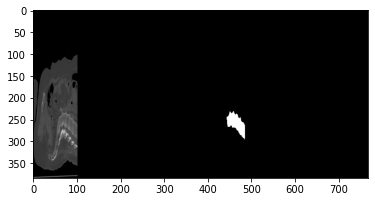

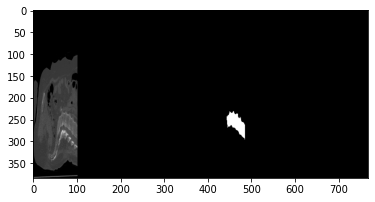

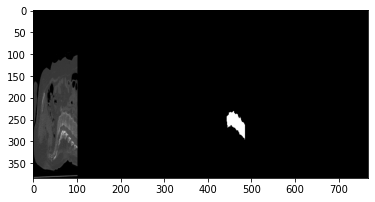

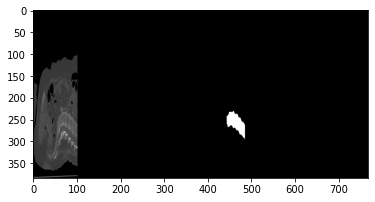

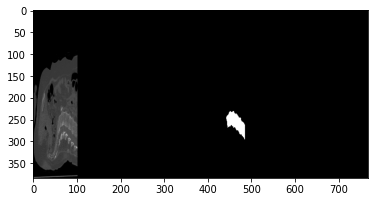

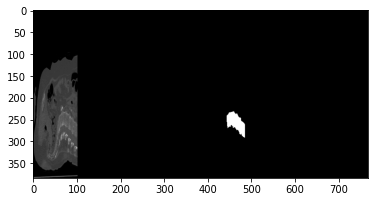

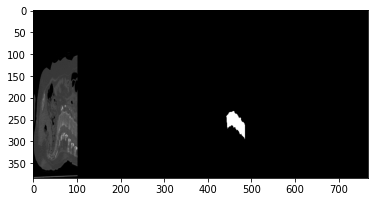

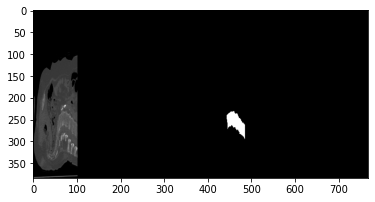

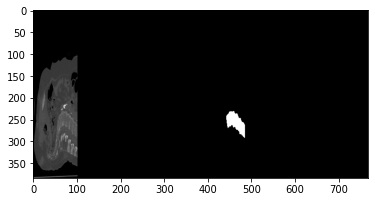

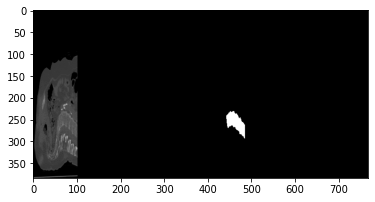

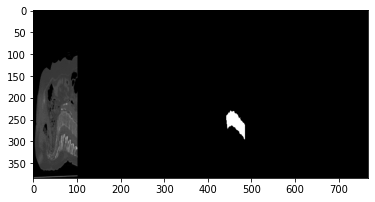

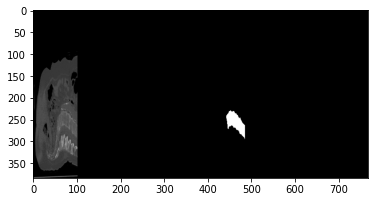

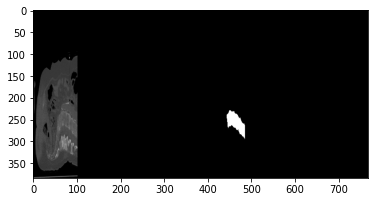

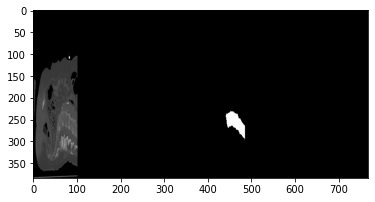

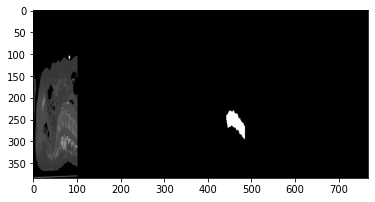

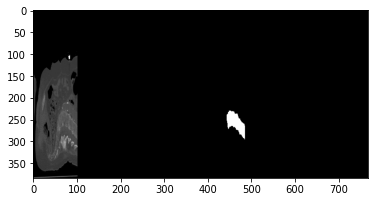

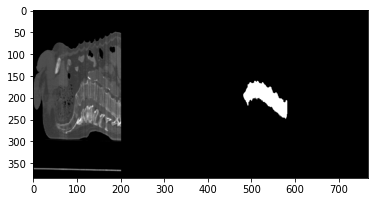

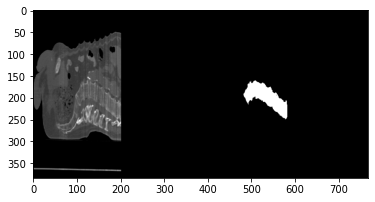

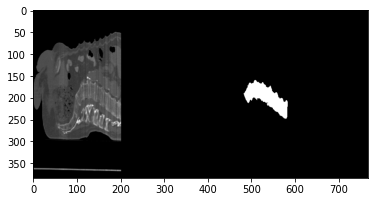

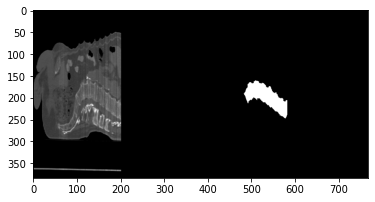

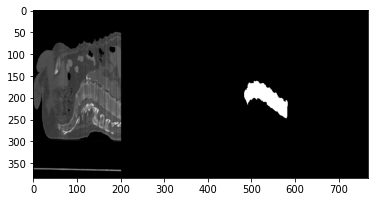

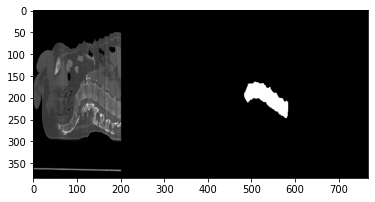

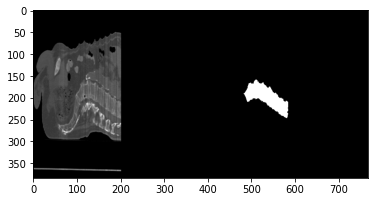

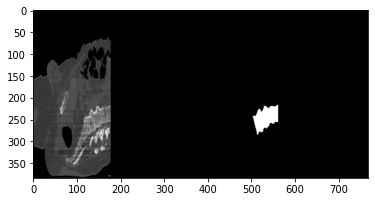

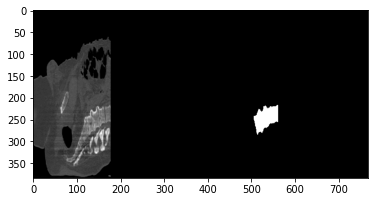

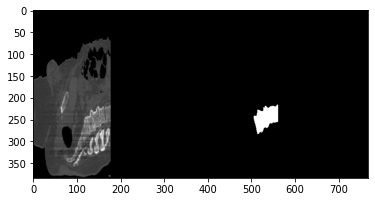

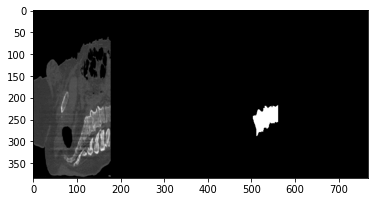

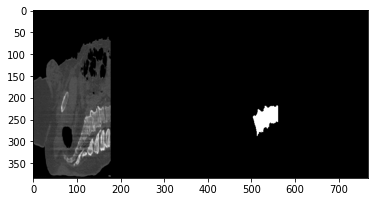

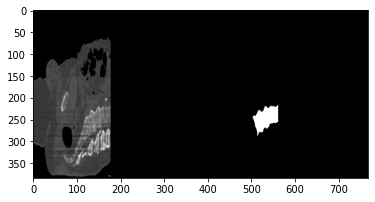

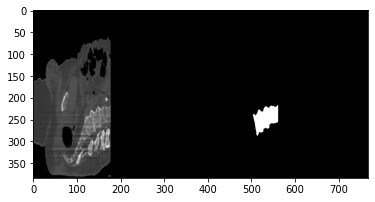

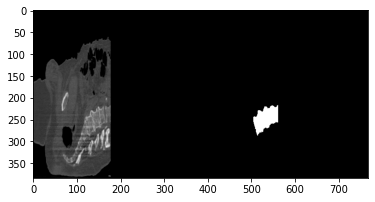

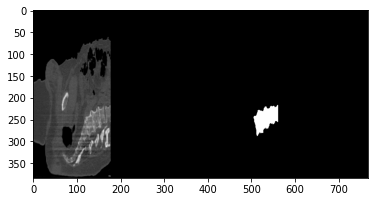

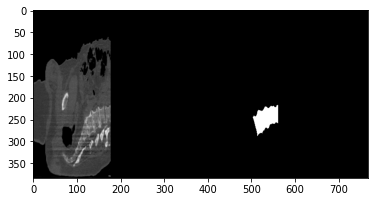

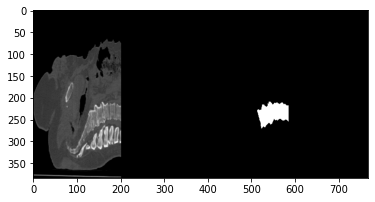

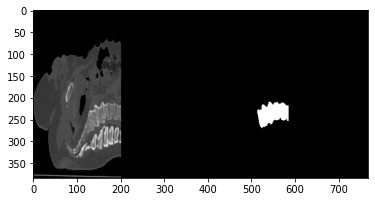

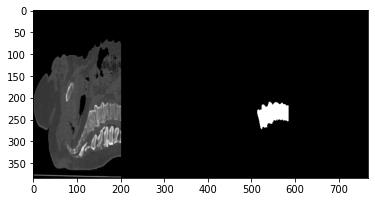

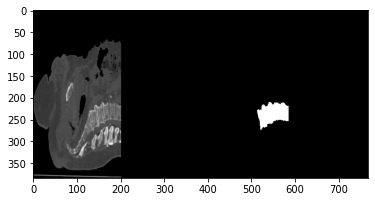

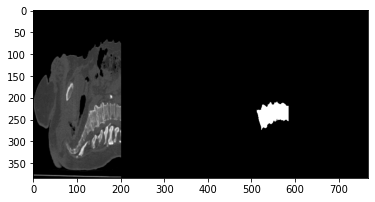

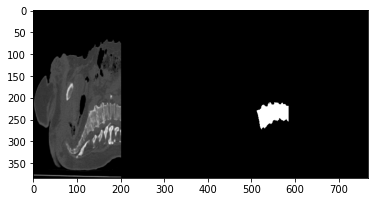

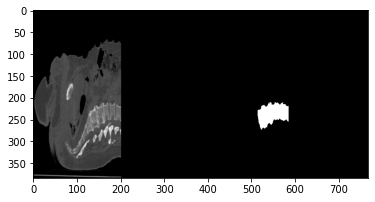

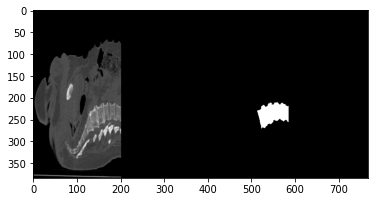

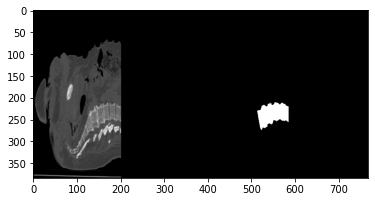

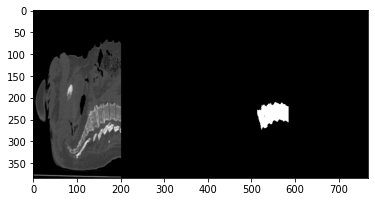

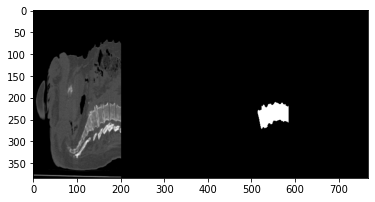

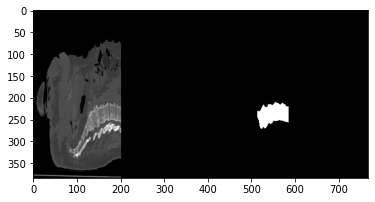

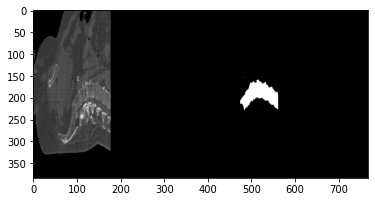

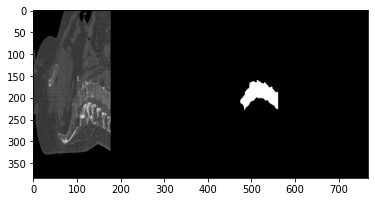

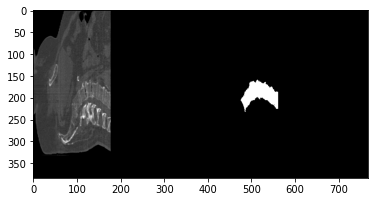

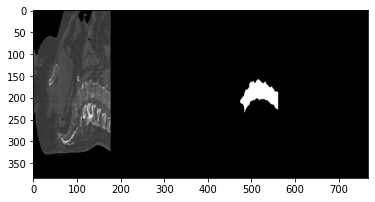

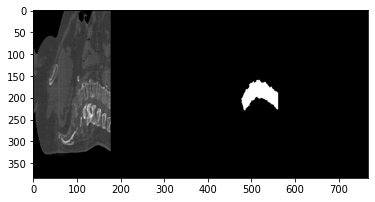

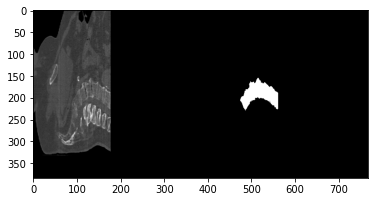

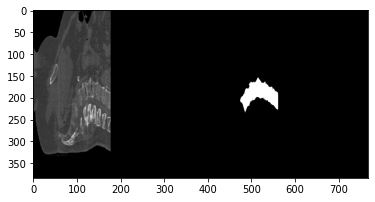

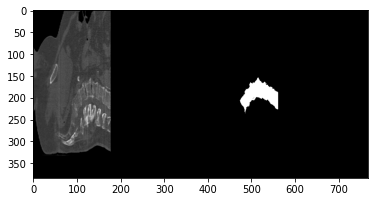

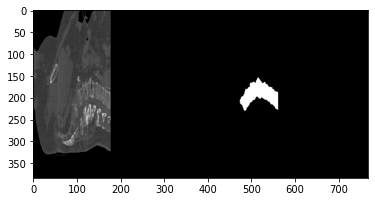

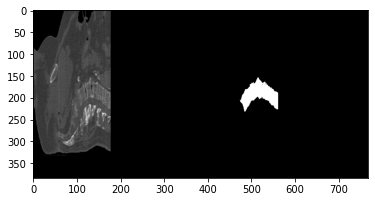

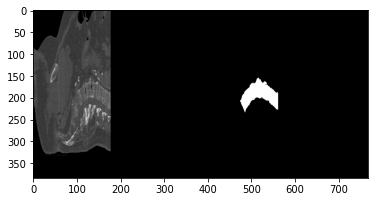

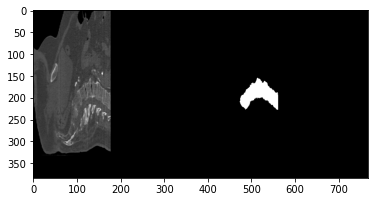

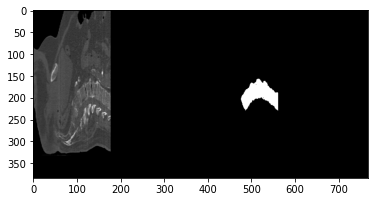

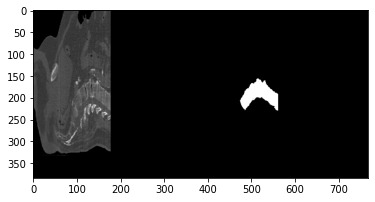

In [10]:
for i, elem in enumerate(a):
    out_img = np.hstack([a[i], b[i]])
    plt.imshow(out_img, cmap=plt.cm.gray)
    plt.show()

In [11]:
inputs = Input((384, 384, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['batch_normalization[0][0]']    
                                )                                                             

In [12]:
beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0


initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [13]:
model.compile(adam_v2.Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

In [14]:
model.fit(train_imgs, train_msks, batch_size=10, epochs=100, callbacks=callbacks, validation_data=[valid_imgs, valid_msks])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.8115 - binary_crossentropy: 0.6524 - generalized_dice_coefficient: 0.0293
Epoch 1: val_loss improved from inf to 0.81536, saving model to mymodel_1.h5
20/20 [==============================] - 19s 277ms/step - loss: 0.8115 - binary_crossentropy: 0.6524 - generalized_dice_coefficient: 0.0293 - val_loss: 0.8154 - val_binary_crossentropy: 0.6671 - val_generalized_dice_coefficient: 0.0372
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.6546 - binary_crossentropy: 0.3180 - generalized_dice_coefficient: 0.0089
Epoch 2: val_loss improved from 0.81536 to 0.73237, saving model to mymodel_2.h5
20/20 [==============================] - 5s 234ms/step - loss: 0.6546 - binary_crossentropy: 0.3180 - generalized_dice_coefficient: 0.0089 - val_loss: 0.7324 - val_binary_crossentropy: 0.4933 - val_generalized_dice_coefficient: 0.0294
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.5149 - bin

In [ ]:
model.save("/content/drive/MyDrive/segmentation/models/my_model_3rd.h5")